# Проект - Анализ бизнес-показателей
### Постановка задачи

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

**Описание последовательности выполнения проекта:** 

* Загружаем данные и готовим их к анализу 
* Задаём функции для расчёта удержания, конверсии, а также LTV, ROI и CAC. Затем создаём функции для визуализации этих метрик
* Проводим исследовательский анализ данных, в котором создаём профили пользователей и узнаём из каких они стран, какими девайсами пользуются, какой канал привлечения их привлёк и сколько они заплатили в данном сервисе
* Изучаем траты на маркетинг - общие и в зависимости от канала привлечения
* Оцениваем окупаемость рекламы с помощью основных метрик (LTV, ROI, CAC). Смотрим на окупаемость рекламы в разрезе устройст, стран и источников привлечения клиентов
* Подводим выводы по проекту



### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка данных и подготовка их к анализу

### Изучение данных из файлов

In [1]:
#Импорт библиотек
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns

#отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
# Загружаем файлы в переменные и выводим на экран
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')

display(visits.head())
display(orders.head())
ad_costs.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [3]:
display(visits.info())
display(orders.info())
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


**Вывод**

В данных нет пропусков, но столбцы стоит привести к регистру snakecase

Так же поменяем тип данных в столбцах с датами, приведём их к типу datetime

### Предобработка данных

#### Переименование столбцов

In [4]:
visits = visits.rename(columns={'User Id':'user_id', 'Session Start':'session_start', 'Session End':'session_end'})
visits.columns = [x.lower() for x in visits.columns]

orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt'})
orders.columns = [x.lower() for x in orders.columns]

ad_costs.columns = [x.lower() for x in ad_costs.columns]

#### Обработка дубликатов

In [5]:
print('Количество дубликатов в таблице visits:', visits.duplicated().sum())

print('Количество дубликатов в таблице orders:', orders.duplicated().sum())

print('Количество дубликатов в таблице ad_costs:', ad_costs.duplicated().sum())

Количество дубликатов в таблице visits: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице ad_costs: 0


**Дубликатов не обнаружено**

#### Изменение типов данных столбцов

Приведём столбцы с датами к типу datetime, а также изменим тип данных в некоторых категориальных столбцах

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits['channel'] = visits['channel'].astype('category')
visits['region'] = visits['region'].astype('category')
visits['device'] = visits['device'].astype('category')

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

### Функция get_profiles

In [7]:
def get_profiles(sessions, orders, ad_costs):
    
    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start':'first',
                'channel':'first',
                'device':'first',
                'region':'first'
            }
        )
        # время первого посещения назовём first_ts
        .rename(columns={'session_start':'first_ts'})
        .reset_index() # возвращаем user_id из индекса
    )
    
    # для когортного анализа определяем дату первого посещения
    profiles['dt'] = profiles['first_ts'].dt.date
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'])
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id':'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id':'unique_users'})
        .reset_index() # возвращаем dt и channel из индексов
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    
    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles # возвращаем профили с CAC

In [8]:
profiles = get_profiles(visits, orders, ad_costs)

In [9]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,False,0.230769


### Функция get_retention

In [10]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon=False):
    
    # добавляем измерение payer в измерения по умолчанию
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам 
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique') 
        
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns = {'user_id': 'cohort_size'})) 
        
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        result = result.div(result['cohort_size'], axis = 0)                                                     
        result = result[['cohort_size'] + list(range(horizon_days))]                                             
        result['cohort_size'] = cohort_sizes                                                                     
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14)

In [12]:
retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,134200,1.0,0.176811,0.086356,0.051468,0.034493,0.024516,0.018443,0.013994,0.011818,0.009478,0.007750,0.006610,0.005872,0.004575
True,8420,1.0,0.404751,0.316746,0.259739,0.226841,0.209264,0.187767,0.173634,0.162589,0.150950,0.149406,0.137173,0.133373,0.121496


**Функция удержания работает**

#### Проверка функции удержания

In [13]:
report = profiles.query(
     # в профилях находим пользователей, привлечённых с 1 мая по 19 октября
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 19).date()'
)
print(
    # считаем уникальных пользователей в профилях и складываем размеры когорт
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), retention['cohort_size'].sum()
    )
)

report = profiles.query(
    # в профилях находим платящих пользователей, привлечённых с 1 мая по 19 октября
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 19).date() and payer == True'
)
print(
    # считаем уникальных платящих пользователей в профилях 
    # и складываем размеры платящих когорт
    'Общее количество новых покупателей: {} {}'.format(
        len(report['user_id'].unique()),
        retention.query('payer == True')['cohort_size'].sum(),
    )  
) 

Общее количество новых пользователей: 142620 142620
Общее количество новых покупателей: 8420 8420


**Функция удержания проверку прошла**

#### Функция визуализации удержания

In [14]:
def plot_retention(retention):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — один столбец и две строки, две ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    plt.show()

### Функция get_conversion

In [15]:
def get_conversion(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt':'first'})
        .reset_index()
    )
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
    
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time     

In [16]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14)

In [17]:
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,142620,0.04092,0.046705,0.049516,0.051522,0.052973,0.053898,0.054677,0.055392,0.055946,0.056458,0.056738,0.056977,0.057145,0.057369


**Функция конверсии работает**

#### Проверка функции конверсии

In [18]:
report = profiles.query(
    # в профилях находим пользователей, привлечённых с 1 мая по 19 октября
    'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 19).date()'
)
print(
    # считаем уникальных пользователей в профилях и складываем размеры когорт
    'Общее количество новых пользователей: {} {}'.format(
        len(report['user_id'].unique()), conversion['cohort_size'].sum()
    )
) 

Общее количество новых пользователей: 142620 142620


**Общее количество новых пользователей совпадает**

In [19]:
# рассчитываем число покупателей по данным из таблицы конверсии

print(
    'Количество уникальных покупателей из таблицы конверсии: {:.0f}'.format(
        conversion['cohort_size'][0] * conversion[13][0]
    )
) 

Количество уникальных покупателей из таблицы конверсии: 8182


In [20]:
# рассчитываем число покупателей по данным о покупках

# берём данные пользователей, привлечённых между 1 мая и 19 октября
report = orders.merge(
    profiles.query(
        'datetime(2019, 5, 1).date() <= dt <= datetime(2019, 10, 19).date()'
    ),
    on='user_id',
)

# рассчитываем лайфтайм для каждой покупки
report['lifetime'] = (report['event_dt'] - report['first_ts']).dt.days
# исключаем лишние лайфтаймы
report = report.query('lifetime <= 13')

print(
    'Количество уникальных покупателей из таблицы заказов: {:.0f}'.format(
        len(report['user_id'].unique())
    )
) 

Количество уникальных покупателей из таблицы заказов: 8182


**Количество уникальных пользователей также совпадает.
  Функция конверсии прошла обе проверки**

#### Функция визуализации конверсии

In [21]:
def plot_conversion(conversion):

    # задаём размер сетки для графиков
    plt.figure(figsize=(22, 12))

    # исключаем размеры когорт и удержания первого дня
    report = conversion.drop(columns=['cohort_size'])
    
    ax1 = plt.subplot(2, 2, 1)
    sns.heatmap(
    report, annot=True, fmt='.1%', ax=ax1)  # в первой ячейке таблицы графиков строим тепловую карту
    plt.title('Тепловая карта конверсии')
    plt.xlabel('Лайфтайм')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2)
    report.T.plot(
    ax=ax2, grid=True, xticks=list(report.columns.values))  # во второй — кривые конверсии
    plt.title('Кривые конверсии')
    plt.xlabel('Лайфтайм')

    plt.show()

### Функция get_ltv_roi

In [22]:
def get_ltv_roi(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # добавляем признак cohort, чтобы не сломать функцию при вызове её без параметра dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        # считаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # считаем LTV:
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        
        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        
        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
        
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        
        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
        
        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']
        
        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    
    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    
    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
        
    # получаем таблицы динамики LTV и ROI 
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция для сглаживания датафрейма

In [23]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция визуализации LTV, ROI и САС

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=3):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Разбивка трат на рекламу по времени

In [25]:
min_date = datetime(2019, 5, 1)
max_date = datetime(2019, 10, 27)
days_num = (max_date - min_date).days
daily_costs = []
for index, values in ad_costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

In [26]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

#### Проверка ltv

In [27]:
max_horizon = int(ltv_raw['lifetime'].max() + 1)

# находим максимальный момент анализа
max_date = profiles['dt'].max()

print(max_horizon, max_date) 

184 2019-10-27


**Максимальный момент анализа - 184 дня**

In [28]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
    profiles, orders, max_date, max_horizon, ignore_horizon=True
)

In [29]:
print(
    'Общая стоимость заказов из таблицы LTV: {:.2f}'.format(
        ltv.loc['All users', 183] * ltv.loc['All users', 'cohort_size']
    )
)

print(
    'Общая стоимость заказов из таблицы заказов: {:.2f}'.format(
        orders['revenue'].sum()
    )
) 

Общая стоимость заказов из таблицы LTV: 215962.88
Общая стоимость заказов из таблицы заказов: 215962.88


**LTV прошёл проверку**

#### Проверка cac

In [30]:
max_acquisition_date = roi_history.reset_index()['dt'].max() #запишем последнюю дату привлечения пользователей

In [31]:
print(
   'Общие расходы на привлечение из таблицы ROI: {:.2f}'.format(
       roi.loc['All users', 'cac'] * roi.loc['All users', 'cohort_size']
   )
)

print(
   'Общие расходы на привлечение из таблицы costs: {:.2f}'.format(
       ad_costs.query('dt <= @max_acquisition_date')['costs'].sum()
   )
) 

Общие расходы на привлечение из таблицы ROI: 105497.30
Общие расходы на привлечение из таблицы costs: 105497.30


**САС прошёл проверку, следовательно и ROI будет правильный**

## Исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Минимальная и максимальная даты привлечения

In [32]:
profiles['dt'].max()

datetime.date(2019, 10, 27)

In [33]:
profiles['dt'].min()

datetime.date(2019, 5, 1)

**Минимальная дата привлечения - 1 мая, максимальная - 27 октября**

### Страны

Создадим сводную таблицу по платящим и неплатящим пользователям по странам

In [34]:
countries = profiles.pivot_table(index='region', columns='payer', values='user_id', aggfunc='nunique')
countries['total_users'] = countries[0] + countries[1]
countries['payers_percentage'] = countries[1] / countries['total_users'] * 100
countries = countries.round(2)

In [35]:
countries.sort_values(by=1, ascending=False)

payer,False,True,total_users,payers_percentage
region,,,,
United States,93100,6902,100002,6.90
UK,16875,700,17575,3.98
France,16787,663,17450,3.80
Germany,14365,616,14981,4.11


Теперь строим столбчатые диаграммы по полученной таблице

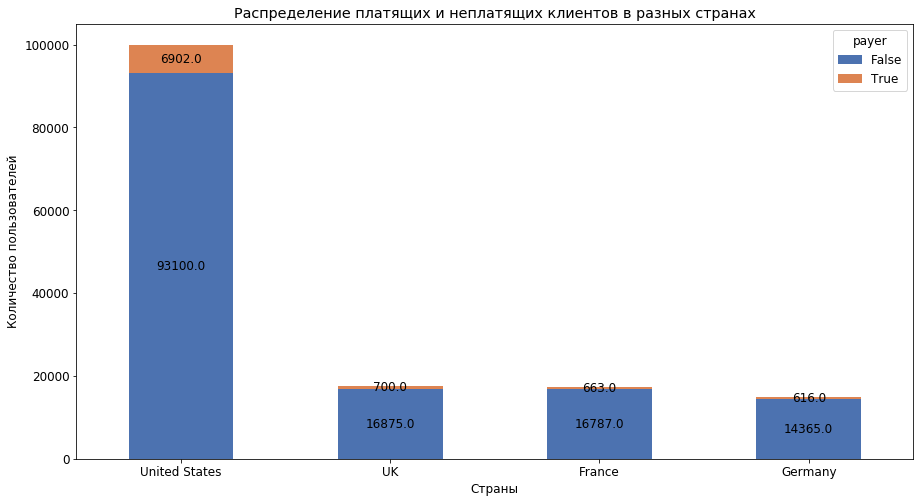

In [36]:
plt.rcParams.update({'font.size': 12})
sns.set_palette('deep') 

ax = (countries[[0,1]].sort_values(by=1, ascending=False)
                      .plot(kind='bar', stacked=True, figsize=(15,8), rot=0, 
                       title='Распределение платящих и неплатящих клиентов в разных странах'))

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{height}'  
    
    label_x = x + width / 2
    label_y = y + height / 2

    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

plt.xlabel('Страны')
plt.ylabel('Количество пользователей')

plt.show()

**Выводы**

* Больше всего клиентов находятся в США (100000), платящих клиентов так же больше всего в этой стране (6900). Франция и Великобритания находятся примерно на одном уровне по общему количеству клиентов (17500), платящих чуть больше в последней (700) против (660) во Франции. В Германии пользователей меньше (15000 - всего) и 616 платящих.

### Девайсы

Аналогично прошлому пункту - создаёт таблицу с клиентами с разбивкой по устройствам

In [37]:
devices = profiles.pivot_table(index='device', columns='payer', values='user_id', aggfunc='nunique')
devices['total_users'] = devices[0] + devices[1]
devices['payers_percentage'] = devices[1] / devices['total_users'] * 100
devices = devices.round(2)

Построение графика распределения клиентов по устройствам

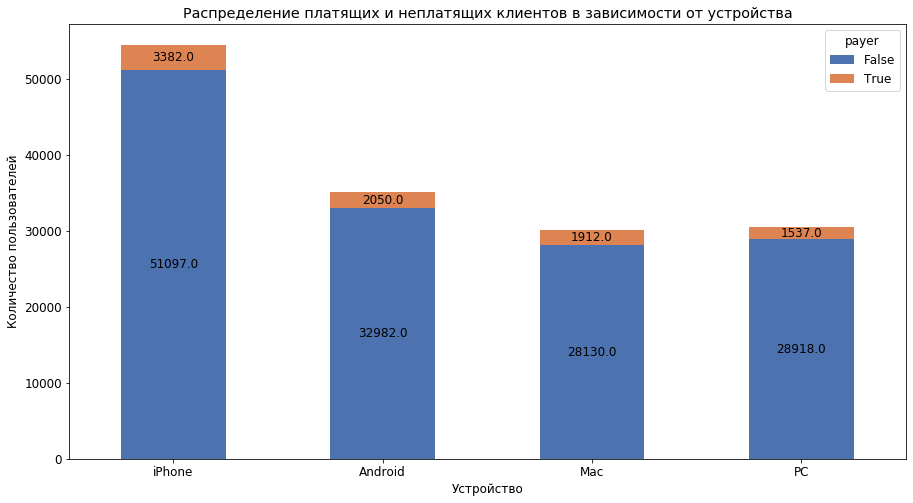

In [38]:
ax = (devices[[0,1]].sort_values(by=1, ascending=False)
                    .plot(kind='bar', stacked=True, figsize=(15,8), rot=0, 
                     title='Распределение платящих и неплатящих клиентов в зависимости от устройства'))

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{height}'  
    
    label_x = x + width / 2
    label_y = y + height / 2

    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

plt.xlabel('Устройство')
plt.ylabel('Количество пользователей')

plt.show()

**Вывод**

* Больше всего платящих клиентов находится в категории клиентов, пользующиеся iPhone (3382). Затем идут пользователи Android (2050) и пользователи Mac (1912). Меньше всего платящих клиентов в категории PC (1537).

### Реклама

Аналогично прошлому пункту - таблица платящих и неплатящих клиентов в зависимости от канала привлечения

In [39]:
channels = profiles.pivot_table(index='channel', columns='payer', values='user_id', aggfunc='nunique')
channels['total_users'] = channels[0] + channels[1]
channels['payers_percentage'] = channels[1] / channels['total_users'] * 100
channels= channels.round(2)

In [40]:
channels.sort_values(by=1, ascending=False)

payer,False,True,total_users,payers_percentage
channel,,,,
FaceBoom,25587,3557,29144,12.20
TipTop,17683,1878,19561,9.60
organic,55279,1160,56439,2.06
WahooNetBanner,8100,453,8553,5.30
AdNonSense,3440,440,3880,11.34
RocketSuperAds,4096,352,4448,7.91
LeapBob,8291,262,8553,3.06
OppleCreativeMedia,8372,233,8605,2.71
lambdaMediaAds,1924,225,2149,10.47


Построение графиков

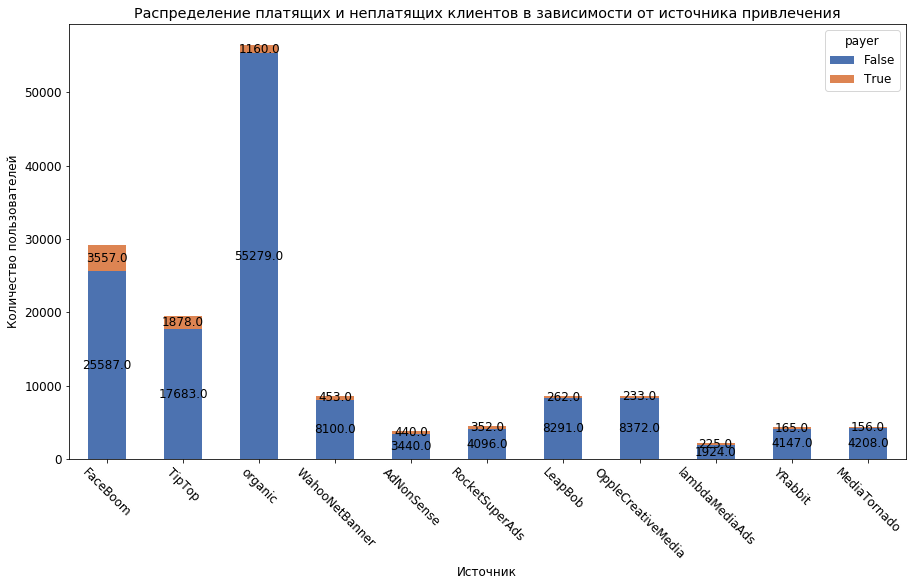

In [41]:
ax = (channels[[0,1]].sort_values(by=1, ascending=False)
                     .plot(kind='bar', stacked=True, figsize=(15,8), rot=-45, 
                      title='Распределение платящих и неплатящих клиентов в зависимости от источника привлечения'))

for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{height}'  
    
    label_x = x + width / 2
    label_y = y + height / 2

    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)

plt.xlabel('Источник')
plt.ylabel('Количество пользователей')

plt.show()

**Выводы**

* Больше всего платящих клиентов привлекает источник FaceBoom (3557) и TipTop (1878), остальные источники привлекают платящих клиентов хуже, чем "органические клиенты" (1160)

## Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Сколько потратили

#### Общие затраты

In [42]:
costs_total = ad_costs['costs'].sum()
costs_total.round(1)

105497.3

**Всего на рекламу потратили 105497.3 единиц**

#### Затраты по источнику привлечения

In [43]:
costs_by_channel = ad_costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)
costs_by_channel

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Теперь визуализация

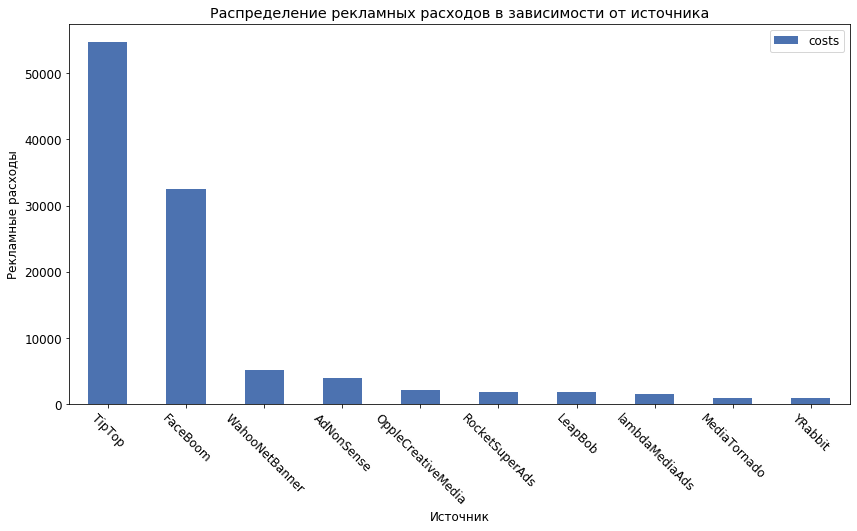

In [44]:
costs_by_channel.plot(kind='bar', figsize=(14,7), rot=-45,
                      title='Распределение рекламных расходов в зависимости от источника')

plt.xlabel('Источник')
plt.ylabel('Рекламные расходы')

plt.show()

**Выводы**

* Львиная доля рекламных расходов уходит на источники привлечения TipTop (54750) и Faceboom (32500), на другие источники уходит уже значительно меньше финансов (<5200). Расходы на источник TipTop составляют больше половины (52%) от общих расходов (105500).

#### Затраты во времени

Строим сводную таблицу всех рекламных расходов с течением времени

In [45]:
costs_by_time = ad_costs.pivot_table(index='dt', values='costs')
costs_by_time

,costs
dt,
2019-05-01,30.4820
2019-05-02,23.0845
2019-05-03,26.3070
2019-05-04,33.7000
2019-05-05,31.9905
...,...
2019-10-23,59.2995
2019-10-24,73.7590
2019-10-25,86.2600


Визуализация полученных значений

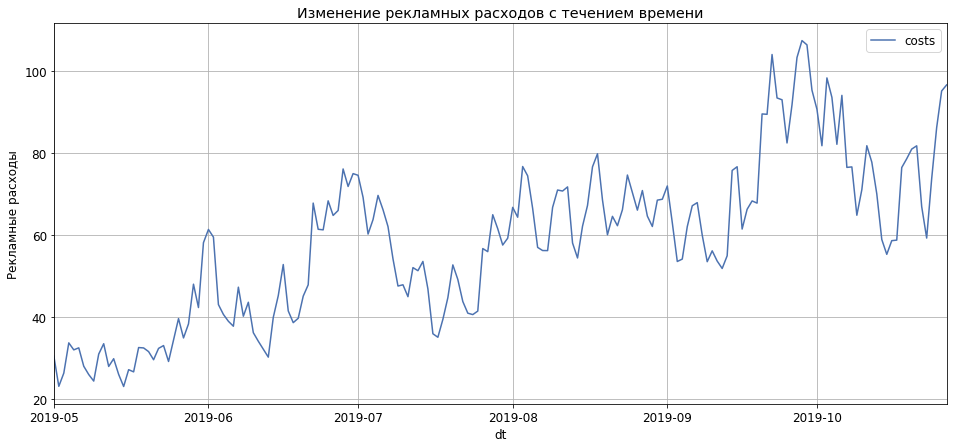

In [46]:
costs_by_time.plot(kind='line', figsize=(16,7), grid=True, 
                   title='Изменение рекламных расходов с течением времени')

plt.ylabel('Рекламные расходы')
plt.show()

Теперь визуализация расходов во времени в зависимости от канала привлечения

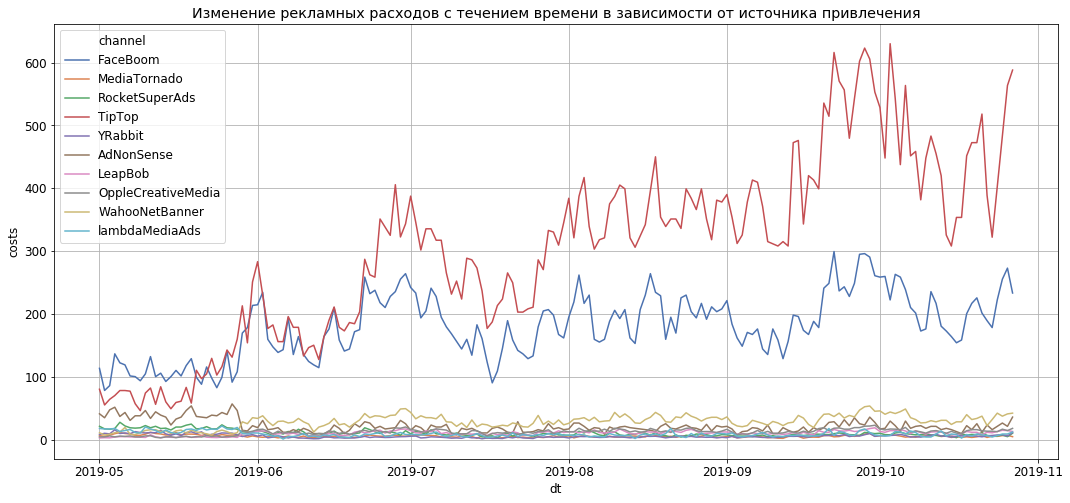

In [47]:
fig, ax = plt.subplots(figsize=(18,8))

sns.lineplot(data=ad_costs, x='dt', y='costs', hue='channel', ax=ax)

plt.title('Изменение рекламных расходов с течением времени в зависимости от источника привлечения')
plt.grid()

plt.show()

**Выводы**

* Кривая изменения общих рекламных расходов показывает, что расходы на рекламу с течением времени значительно выросли, с 30 долларов до 100 примерно за полгода

* Кривая изменения рекламных расходов по источникам привлечения наглядно показывает, что расходы на большинство источников находились на одном стабильно уровне, а расходы на источники TipTop и FaceBoom значительно выросли за полгода

### Стоимость одного пользователя

#### Общая стоимость одного пользователя

In [48]:
cac_total = roi.loc['All users']['cac'].round(2)
cac_total

0.7

**Общая стоимость одного клиента составляет 0.7 единиц**

#### Стоимость одного пользователя с разбивкой по источникам

In [49]:
cac_by_channel = (profiles.pivot_table(index='channel', values='acquisition_cost')
                          .sort_values(by='acquisition_cost', ascending=False))

cac_by_channel = cac_by_channel.query('channel != "organic"')
cac_by_channel

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


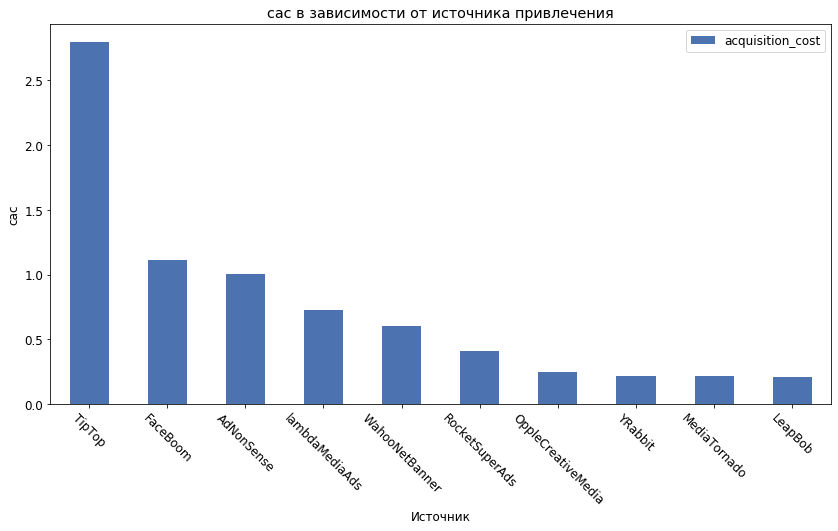

In [50]:
cac_by_channel.plot(kind='bar', figsize=(14,7), rot=-45, title='cac в зависимости от источника привлечения')

plt.xlabel('Источник')
plt.ylabel('сас')

plt.show()

**Выводы**

* Самую высокую стоимость привлечения одного клиента имеет источник TipTop (cac=2.8), FaceBoom имеет значения уже в 2.5 раза ниже (cac=1.1), Adnonsense (cac=1) на уровне FaceBoom

## Окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проведем анализ общей окупаемости рекламы, окупаемости рекламы с разбивкой по устройствам, по странам и с разбивкой по рекламным каналам

Опишем обнаруженные проблемы. Затем ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Нам будет нужно описать возможные причины обнаруженных проблем и сформировать рекомендации для рекламного отдела. При решении этого шага будем считать, что мы смотрим данные 1-го ноября 2019 года и что в нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Общая окупаемость рекламы

Создадим профили, в которых будут отсутствовать органические пользователи и затем всё визуализируем

In [51]:
marketing_profiles = profiles.query('channel != "organic"')

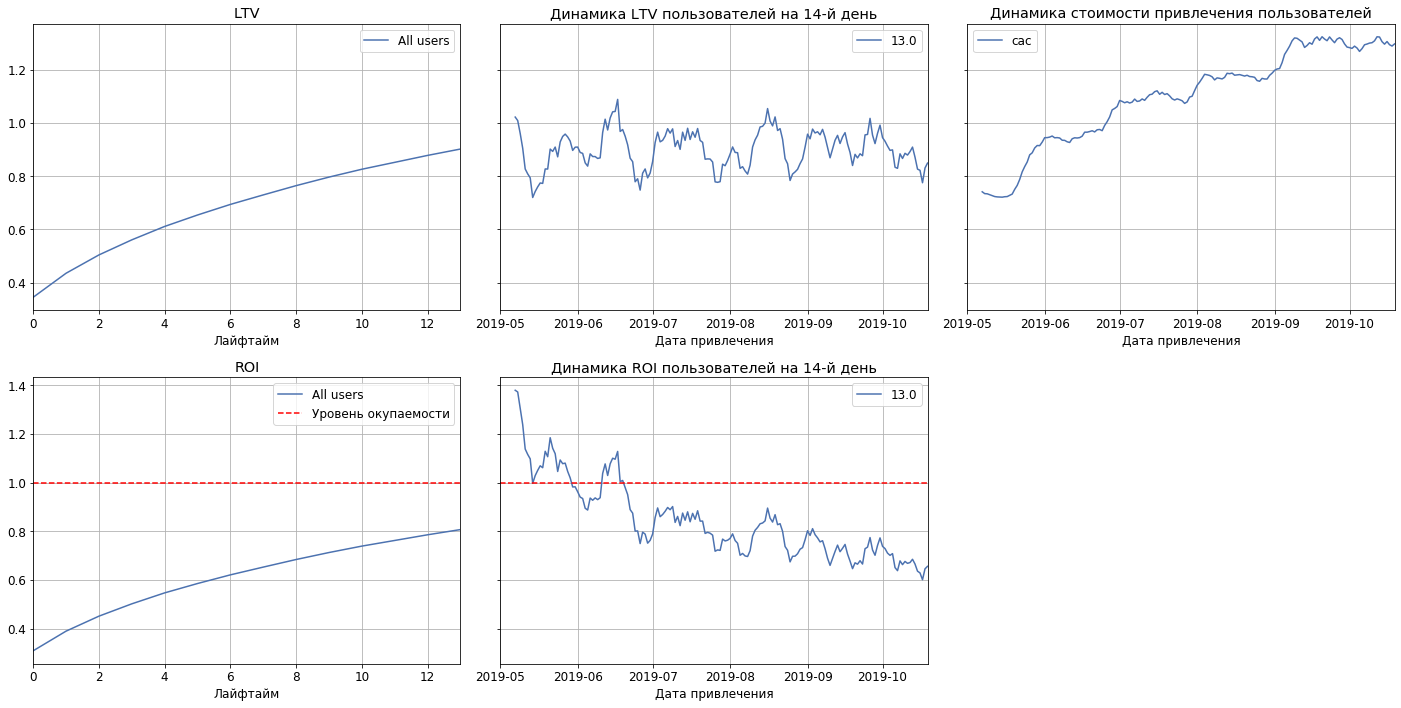

In [52]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
    marketing_profiles, orders, datetime(2019, 11, 1).date(), 14)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, 7)

**Выводы**

* По графикам изменения LTV и CAC заметно насколько кривая CAC выше кривой LTV, что означает убыток рекламной компании. Только в небольшой промежуток времени от мая до июня и затем в середине июня был прибыльный период, что показывает динамика изменения ROI
* По графику ROI видно, что общая окупаемость к концу второй недели жизни пользователя находится на уровне ROI=0.8
* По графику динамики ROI можно сказать, что к октябрю значение ROI останавливается на значении в 0.7

### Окупаемость рекламы с разбивкой по устройствам

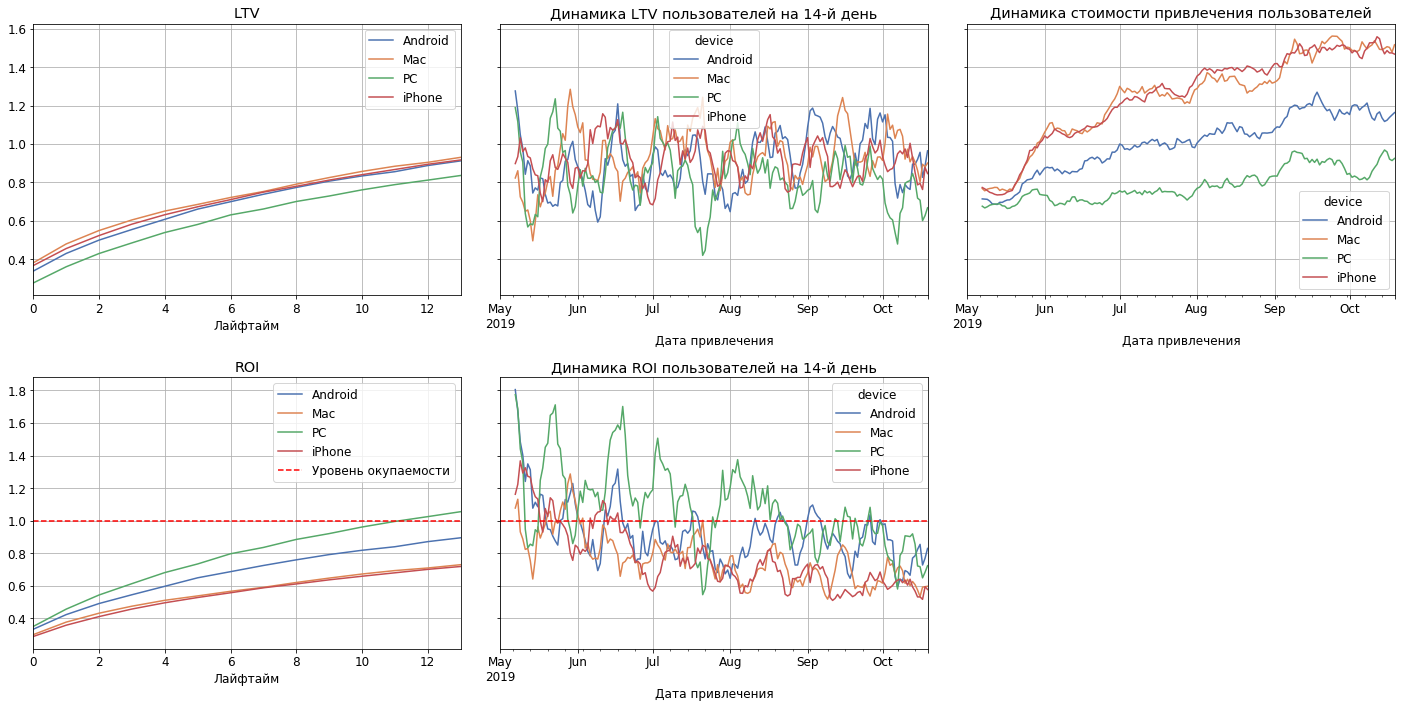

In [53]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
    marketing_profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, 7)

**Выводы**

* Если смотреть по графику LTV, то наиболее ценными клиентами являются пользователи iPhone (LTV=0.92) и Mac (LTV=0.93), чуть меньшая ценность у пользователей Android (LTV=0.91), LTV для платформы PC составляет 0.84. В то же время стоимость привлечения пользователей Mac и Iphone намного выше, чем у пользователей Android и PC. 
* Единственной прибыльной платформой из всех на 14 день жизни пользователя является PC (ROI=1.05). Самыми убыточными платформами являются iPhone (ROI=0.72) и Mac (ROI=0.73), roi на платформе Android составляет 0.89
* Динамика ROI на 14 день жизни пользователей показывает, что с середины июня графики ROI для iPhone и Mac уходят ниже уровня окупаемости, графики ROI для PC бОльшую часть времени оказываются выше уровня окупаемости, графики ROI для Android уже реже

### Окупаемость рекламы с разбивкой по странам

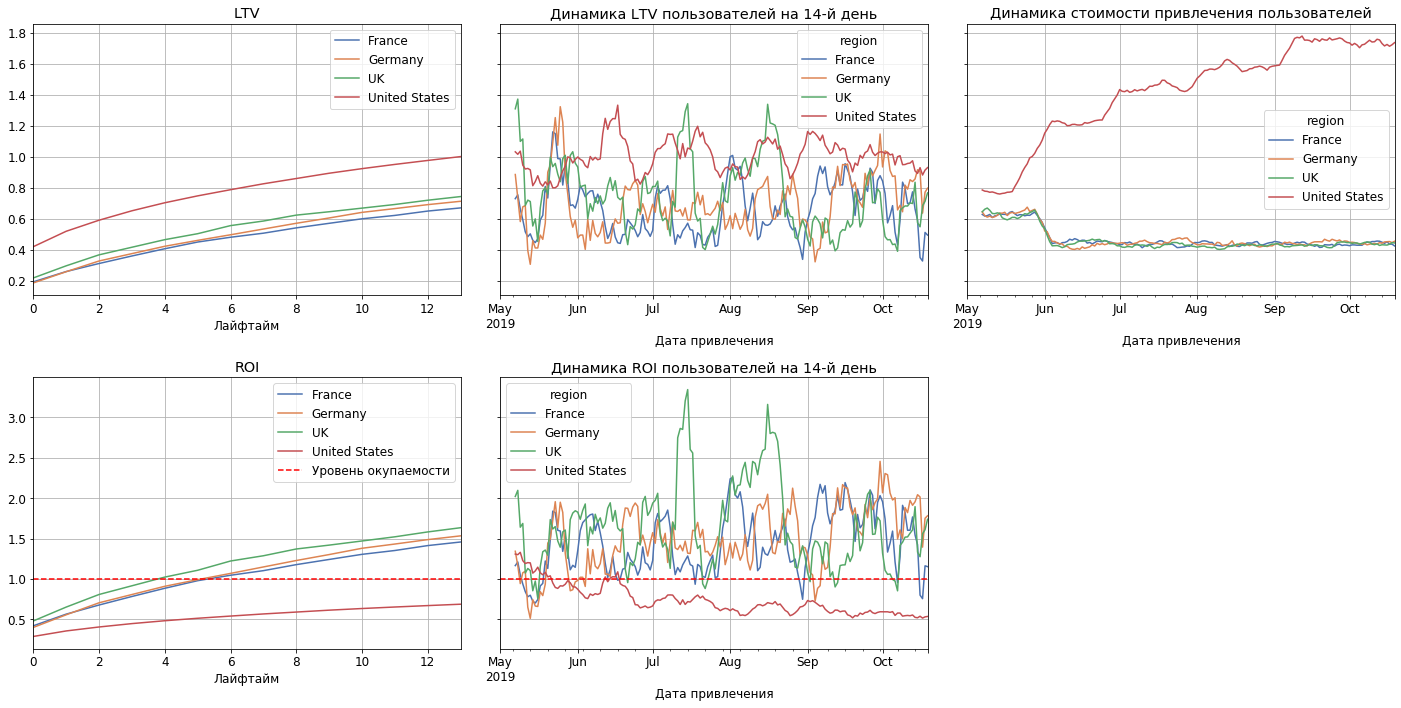

In [54]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
    marketing_profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, 7)

**Выводы**

* Наиболее ценными являются клиенты из США (LTV=1), но они имеют высокий стоимость привлечения и соответственно низкий ROI (0.69). Другие страны держатся примерно на одном уровне ROI - Германия (ROI=1.53), Франция (ROI=1.46), Великобритания (ROI=1.63)

### Окупаемость рекламы с разбивкой по рекламным каналам

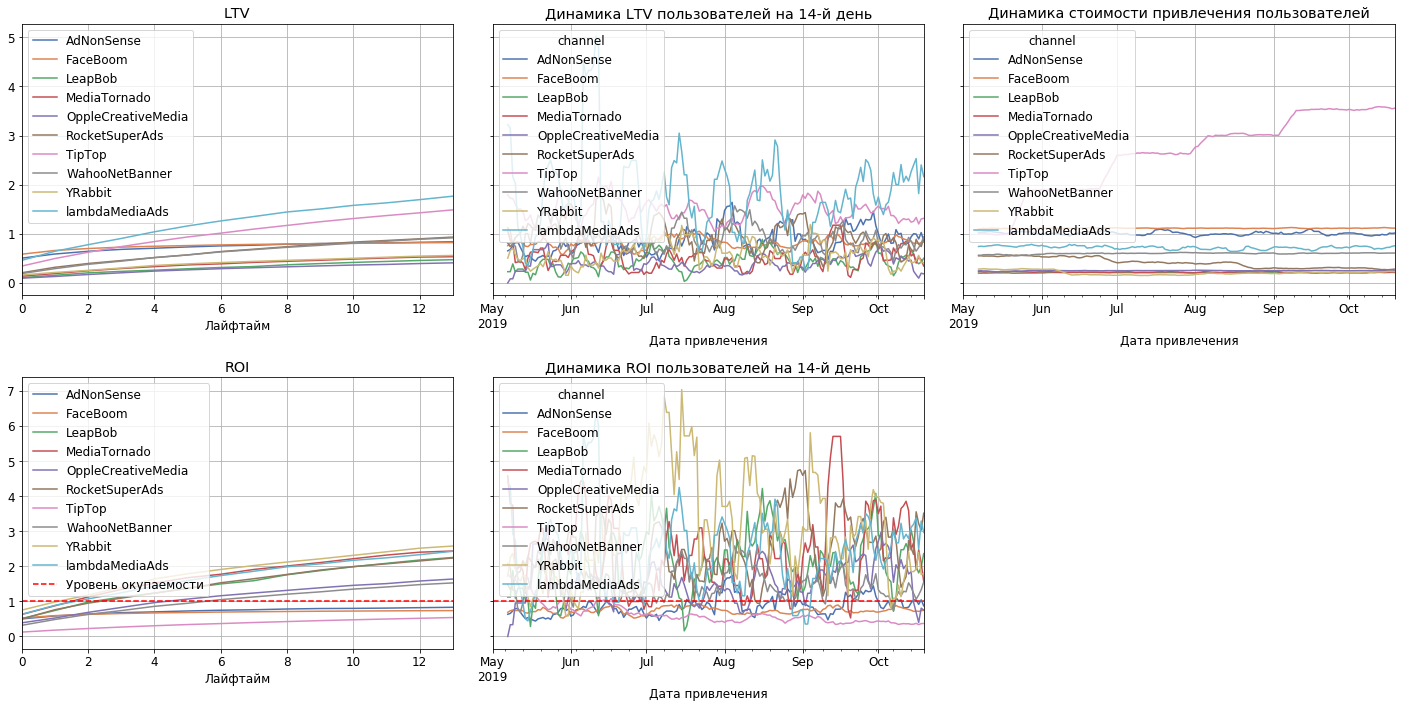

In [55]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv_roi(
    marketing_profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, 7)

**Выводы**

* Наиболее ценными клиентами являются клиенты, которые пришли благодаря источнику lambdaMediaAds и TipTop
* Невероятно высокая стоимость привлечения клиентов имеем источник TipTop. Стоимость привлечения одного клиента стала резко расти с середины мая. При этом CAC в других источниках оставался на стабильном уровне 
* Если смотреть по ROI, то FaceBoom, TipTop и Adnonsense не окупаются. При этом по кривой cac мы можем увидеть, что стоимость привлечения пользователей стоит примерно на одном уровне, но cac по каналу TipTop резко начинает расти примерно с середины мая с 1 до 3,5 LTV в конце октября. Самым выгодным каналом является lambdamediaarts, так как он хорошо окупается и привлекает клиентов с высоким уровнем LTV. Из других каналов так же можно выделить YRabbit и MediaTornado, они окупаются практически двухкратно


### Конверсия и удержание

#### Общая конверсия и удержание

In [56]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14)

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14)

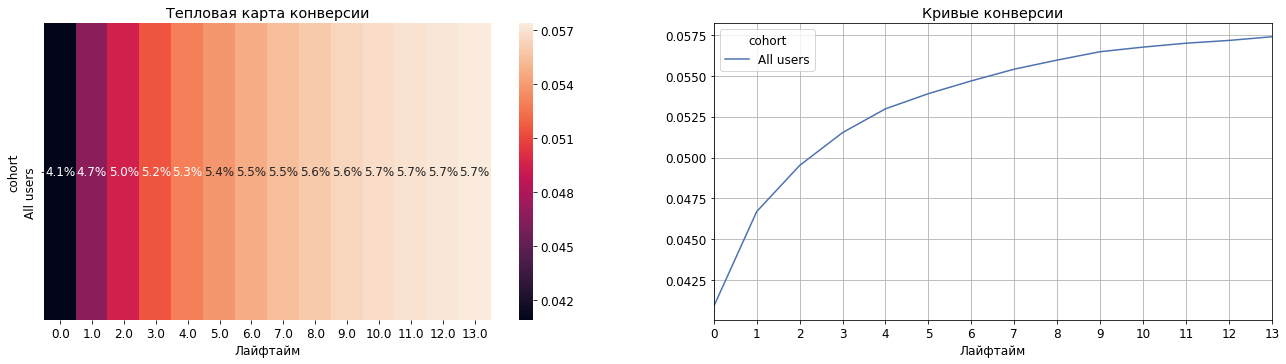

In [57]:
plot_conversion(conversion)

**Выводы**

* Общая конверсия к концу второй недели жизни пользователя составляет 5.75%

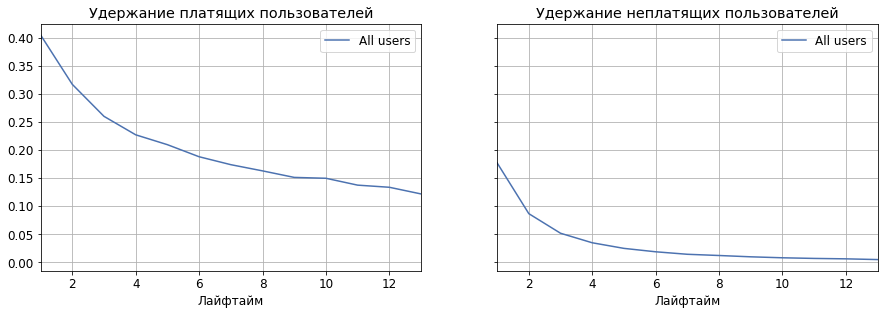

In [58]:
plot_retention(retention)

**Выводы**

* Общее удержание платящих пользователей к концу второй недели достигает 12.5%

* Общее удержание неплатящих пользователей приближается к значению в полпроцента в конце второй недели

#### Разбивка по странам

In [59]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region'])

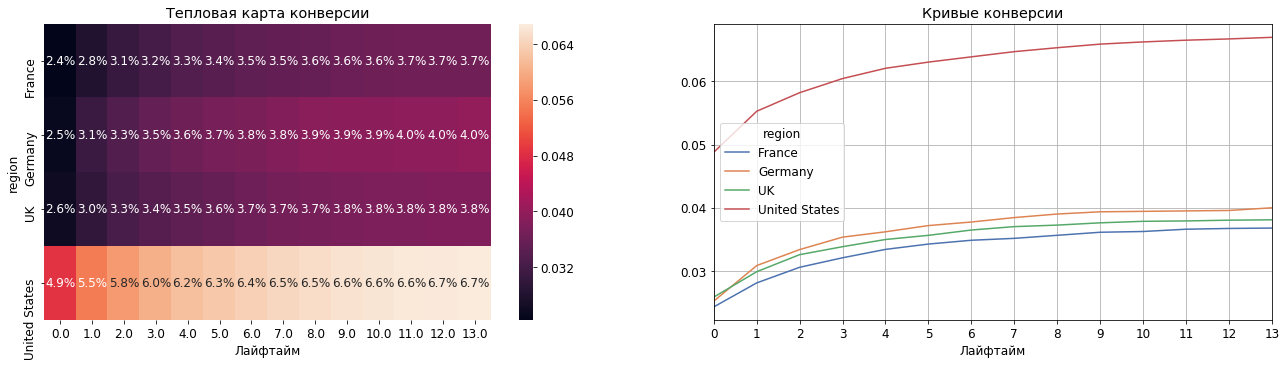

In [60]:
plot_conversion(conversion)

**Выводы**

* Во Франции, Германии и Великобритании наблюдается примерно один уровень конверсии (3.7% - 4% к концу 2 недели).Конверсия пользователей из Америки в конце 2 недели выше примерно в 1.7 раза (6.7%) по сравненнию с другими странами.

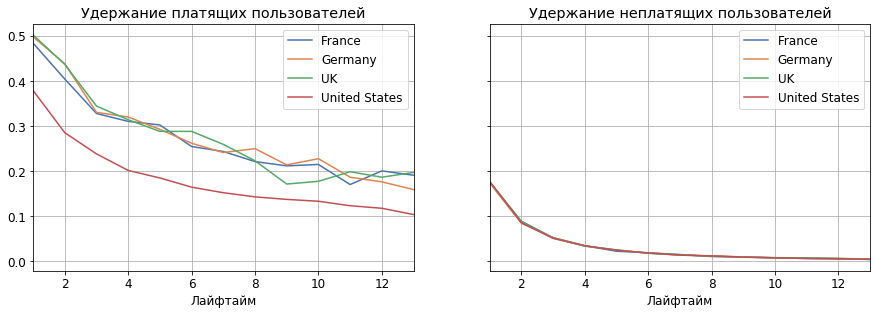

In [61]:
plot_retention(retention)

**Выводы**

* Удержание платящих пользователей из Штатов к концу второй недели меньше (10%), чем в других странах (20%)

* Удержание неплатящих пользователей в разных странах убывает одинаково, достигая значений в полпроцента в конце второй недели

#### Разбивка по девайсам

In [62]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device'])

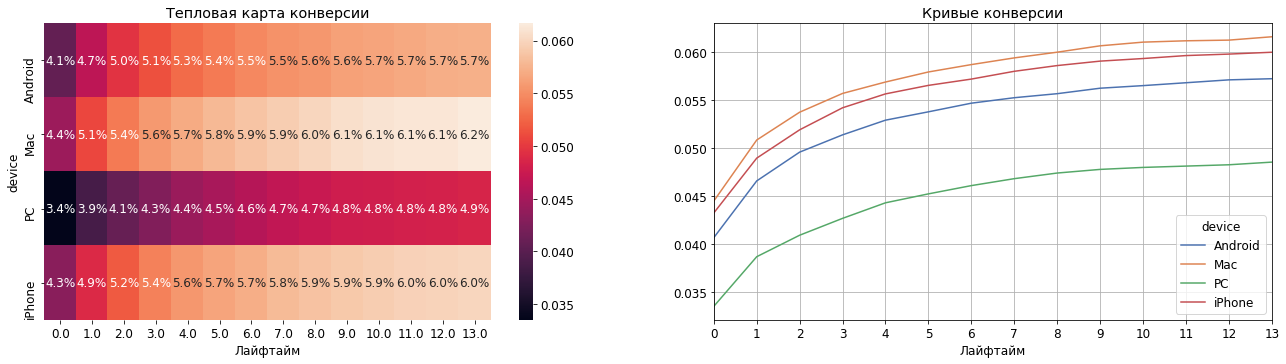

In [63]:
plot_conversion(conversion)

**Выводы**

* Лучшие показатели конверсии к концу второй недели показывают пользователи iPhone (6%) и пользователи Mac (6.2%), чуть меньшая конверсия у пользователей Android (5.7%). Меньшую конверсию имеют пользователи PC (4.9%)

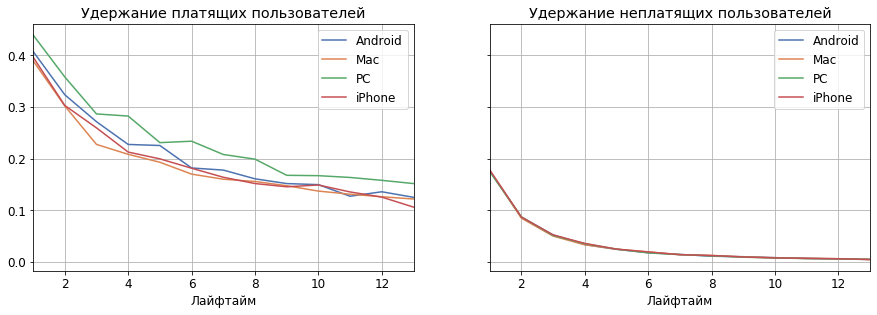

In [64]:
plot_retention(retention)

**Выводы**

* К концу 2 недели у пользователей PC показатель удержания составляет 15%, у пользователей других девайсов он на уровне 10-12%

* Удержание неплатящих пользователей одинаков и достигает значения в полпроцента к концу 2 недели

**Промежуточные выводы**

* Единственными, кто окупаются из пользователей разных девайсов на 14 день жизни пользователя, являются пользователи PC (ROI=1.05). Пользователи других платформ не окупают себя (ROI<1)

* В разрезе стран только одна себя не окупает - это США. Германия, Франция и Великобритания имеют ROI>1

* Если смотреть на ROI по источникам привлечения, то FaceBoom, TipTop и Adnonsense себя не окупают на 14 день жизни пользователя. Самым выгодным каналом является lambdaMediaAds, так как он хорошо окупается и привлекает клиентов с высоким уровнем LTV. Из других каналов так же можно выделить YRabbit и MediaTornado, они окупаются практически двухкратно

## Выводы по исследованию

**Общие выводы:**

* Значительные финансы (52% от рекламного бюджета) регулярно выделялись на рекламный канал TipTop, который на протяжении всего времени исследования был убыточным. Только первые две недели исследования графики динамики ROI был выше черты окупаемости. Кроме того, финансы были выделены на канал Faceboom (31% от рекламного бюджета), который так же оказался полностью убыточным, график динамики ROI на протяжении полугода ни раз не поднялся выше черты окупаемости.

* Привлечение клиентов из США оказалось невыгодным, так как график ROI за 2 недели жизни пользователя не пересекает черту окупаемости. Самой прибыльной из стран оказалась Великобритания - там самый высокий ROI к концу 2 недели.

* Единственной прибыльной платформой из всех на 14 день жизни пользователя является PC (ROI=1.05). Самыми убыточными платформами являются iPhone (ROI=0.72) и Mac (ROI=0.73), ROI на платформе Android составляет 0.89.

* Общий уровень ROI составляет 0.8

**Причины неэффективного привлечения пользователей**

- Привлечение невыгодных клиентов из США. Хотя они приносят сервису больше денег, чем клиенты из других стран, но их привлечение стоит слишком много, что значительно сказывается на окупаемости

- Выделение рекламных средств на неэффективные источники привлечения платящих клиентов. Самыми невыгодными стали TipTop и FaceBoom

- Привлечение невыгодных пользователей iPhone и Mac. Они хорошо конвертируются, но цена их привлечения перекрывает возможность их окупаемости


**Рекомендации:**

* В первую очередь не стоит привлекать клиентов с помощью неокупающихся источников рекламы, таких как TipTop и FaceBoom. Стоит выделять больше рекламных финансов таким источникам, как lambdaMediaAds,YRabbit и MediaTornado, их окупаемость наибольшая из всех

* Стоит привлекать больше пользователей PC, так как они приносят наибольшую прибыль на 14 день жизни клиента

* Стоит привлекать больше клиентов из Великобритании, Германии и Франции, так как они так же приносят больше прибыли. Привлечение клиентов из США показало себя очень невыгодным, если рассматривать окупаемость пользователя на 14 день его жизни